In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
train_dir = '/content/drive/MyDrive/buetpaper/train'
validation_dir = '/content/drive/MyDrive/buetpaper/val'
test_dir='/content/drive/MyDrive/buetpaper/test'

In [84]:
import os
trainclass_subset=os.listdir(train_dir)
validclass_subset =os.listdir(validation_dir)

In [85]:
trainclass_subset

['Stemborer',
 'Brown_Spot',
 'Neck_Blast',
 'BLB',
 'Healthy_Plant',
 'Hispa',
 'BPH',
 'Sheath_Blight_Rot',
 'False_Smut']

In [86]:
validclass_subset

['False_Smut',
 'BLB',
 'Sheath_Blight_Rot',
 'Neck_Blast',
 'BPH',
 'Stemborer',
 'Healthy_Plant',
 'Brown_Spot',
 'Hispa']

In [88]:
import tensorflow 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# **Train Data with simple CNN**

In [89]:
#image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)


In [90]:
# load train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                   )
#load val data
val_generator = val_datagen.flow_from_directory(validation_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )
# load test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )

Found 994 images belonging to 9 classes.
Found 208 images belonging to 9 classes.
Found 224 images belonging to 9 classes.


# **Train with InceptionV3**

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [92]:
inception = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


87924736/87910968 [==============================] - 0s 0us/step


In [93]:
#do not train the pre-trained layers of VGG-19
for layer in inception.layers:
    layer.trainable = False

In [94]:
x = inception.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
output_layer = Dense(9, activation='softmax', name='softmax')(x)
model = Model(inputs=inception.input, outputs=output_layer)
   

In [95]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [96]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0a757747d0> False
<keras.layers.convolutional.Conv2D object at 0x7f0a75774710> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0a7578fa50> False
<keras.layers.core.activation.Activation object at 0x7f0a75a09490> False
<keras.layers.convolutional.Conv2D object at 0x7f0a75776c90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0a7594c490> False
<keras.layers.core.activation.Activation object at 0x7f0a7570e0d0> False
<keras.layers.convolutional.Conv2D object at 0x7f0a75714bd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0a75914510> False
<keras.layers.core.activation.Activation object at 0x7f0a75714f90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0a75721c10> False
<keras.layers.convolutional.Conv2D object at 0x7f0a75914a10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7

In [97]:
from keras.optimizer_v1 import Adam
EPOCHS=30
model.compile(loss="categorical_crossentropy", optimizer="Adam",metrics=["accuracy"])

In [98]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)


In [99]:
modelcheck = ModelCheckpoint('/content/gdrive/MyDrive/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)


In [100]:
history = model.fit_generator(train_generator,validation_data=val_generator,epochs=EPOCHS,verbose=1,callbacks=[es])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
32/32 [==============================] - 21s 504ms/step - loss: 9.7308 - accuracy: 0.3129 - val_loss: 3.6202 - val_accuracy: 0.3846
Epoch 2/30
32/32 [==============================] - 14s 435ms/step - loss: 1.6302 - accuracy: 0.6237 - val_loss: 0.8751 - val_accuracy: 0.7740
Epoch 3/30
32/32 [==============================] - 14s 448ms/step - loss: 1.0525 - accuracy: 0.7072 - val_loss: 0.9598 - val_accuracy: 0.7692
Epoch 4/30
32/32 [==============================] - 14s 441ms/step - loss: 0.6236 - accuracy: 0.8008 - val_loss: 0.4212 - val_accuracy: 0.8558
Epoch 5/30
32/32 [==============================] - 14s 449ms/step - loss: 0.3850 - accuracy: 0.8732 - val_loss: 0.3002 - val_accuracy: 0.8942
Epoch 6/30
32/32 [==============================] - 14s 444ms/step - loss: 0.3966 - accuracy: 0.8672 - val_loss: 0.2766 - val_accuracy: 0.9135
Epoch 7/30
32/32 [==============================] - 14s 437ms/step - loss: 0.3009 - accuracy: 0.8984 - val_loss: 0.3391 - val_accuracy: 0.9038

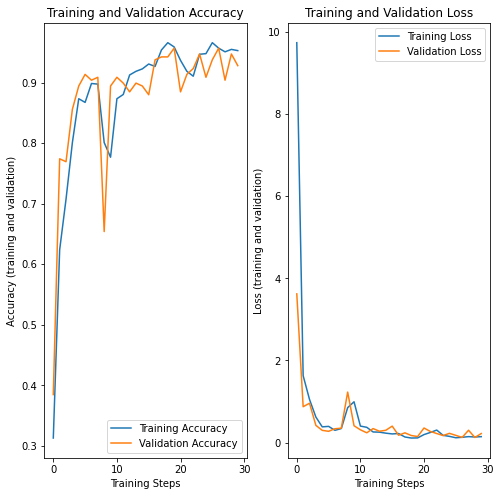

In [101]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [102]:
model.save("/content/drive/MyDrive/VGG16/DenseNetFT.h5")

In [103]:
loss_val, acc_val = model.evaluate(val_generator, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 1s 90ms/step - loss: 0.2223 - accuracy: 0.9279
Validation: accuracy = 0.927885  ;  loss_v = 0.222256


In [104]:
loss_test, acc_test = model.evaluate(test_generator, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

7/7 [==============================] - 2s 208ms/step - loss: 0.4161 - accuracy: 0.9107
Test: accuracy = 0.910714  ;  loss_v = 0.416139


In [105]:
loss_train, acc_train = model.evaluate(train_generator, verbose=1)
print("Train: accuracy = %f  ;  loss_v = %f" % (acc_train, loss_train))

32/32 [==============================] - 13s 406ms/step - loss: 0.1552 - accuracy: 0.9457
Train: accuracy = 0.945674  ;  loss_v = 0.155232


# **Image prediction**

**Test Data Confusion matrix & Classification report**

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt

In [107]:
pred_test = model.predict_generator(test_generator)
pred_test = np.argmax(pred_test, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [108]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(test_generator.classes, pred_test, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.95      0.82      0.88        22
              BPH       0.92      0.92      0.92        12
       Brown_Spot       0.77      0.94      0.85        18
       False_Smut       1.00      1.00      1.00        15
    Healthy_Plant       1.00      0.89      0.94        36
            Hispa       1.00      0.75      0.86        12
       Neck_Blast       0.98      0.95      0.97        44
Sheath_Blight_Rot       0.76      0.94      0.84        34
        Stemborer       0.93      0.90      0.92        31

         accuracy                           0.91       224
        macro avg       0.92      0.90      0.91       224
     weighted avg       0.92      0.91      0.91       224



In [109]:
test_confusion_matrix = confusion_matrix(test_generator.classes, pred_test)
test_confusion_matrix

array([[18,  0,  2,  0,  0,  0,  0,  2,  0],
       [ 0, 11,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 17,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 32,  0,  0,  4,  0],
       [ 0,  0,  1,  0,  0,  9,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0, 42,  0,  2],
       [ 1,  0,  1,  0,  0,  0,  0, 32,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  2, 28]])

In [110]:
test_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        test_sum[i]=test_sum[i]+test_confusion_matrix[i][j]

In [111]:
test_confusion_matrix_percentage = test_confusion_matrix.astype(np.float32)

In [112]:
for i in range(9):
    for j in range(9):
        test_confusion_matrix_percentage[i][j]=test_confusion_matrix_percentage[i][j]/test_sum[i]

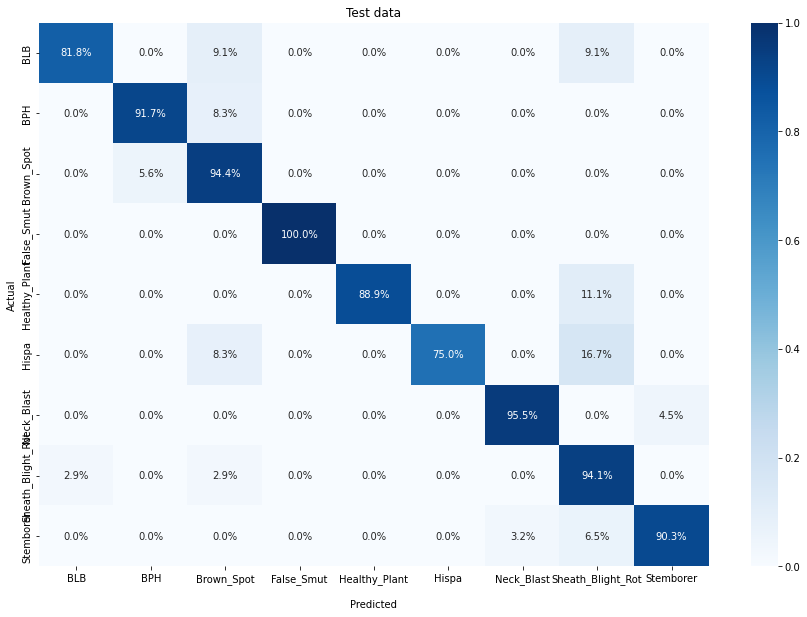

In [113]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(test_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Test data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Validation Data Confusion matrix and classification report**

In [114]:
pred_val = model.predict_generator(val_generator)
pred_val = np.argmax(pred_val, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [115]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(val_generator.classes, pred_val, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.89      0.80      0.84        20
              BPH       1.00      1.00      1.00        10
       Brown_Spot       0.67      1.00      0.80        16
       False_Smut       1.00      0.54      0.70        13
    Healthy_Plant       0.97      0.97      0.97        35
            Hispa       1.00      0.90      0.95        10
       Neck_Blast       1.00      0.98      0.99        42
Sheath_Blight_Rot       0.91      0.94      0.92        32
        Stemborer       0.97      1.00      0.98        30

         accuracy                           0.93       208
        macro avg       0.93      0.90      0.91       208
     weighted avg       0.94      0.93      0.93       208



In [116]:
val_confusion_matrix = confusion_matrix(val_generator.classes, pred_val)
val_confusion_matrix

array([[16,  0,  3,  0,  0,  0,  0,  1,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 16,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  3,  7,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 34,  0,  0,  1,  0],
       [ 0,  0,  1,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 41,  0,  1],
       [ 1,  0,  1,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30]])

In [117]:
val_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        val_sum[i]=val_sum[i]+val_confusion_matrix[i][j]
        
        
val_confusion_matrix_percentage = val_confusion_matrix.astype(np.float32)

for i in range(9):
    for j in range(9):
        val_confusion_matrix_percentage[i][j]=val_confusion_matrix_percentage[i][j]/val_sum[i]


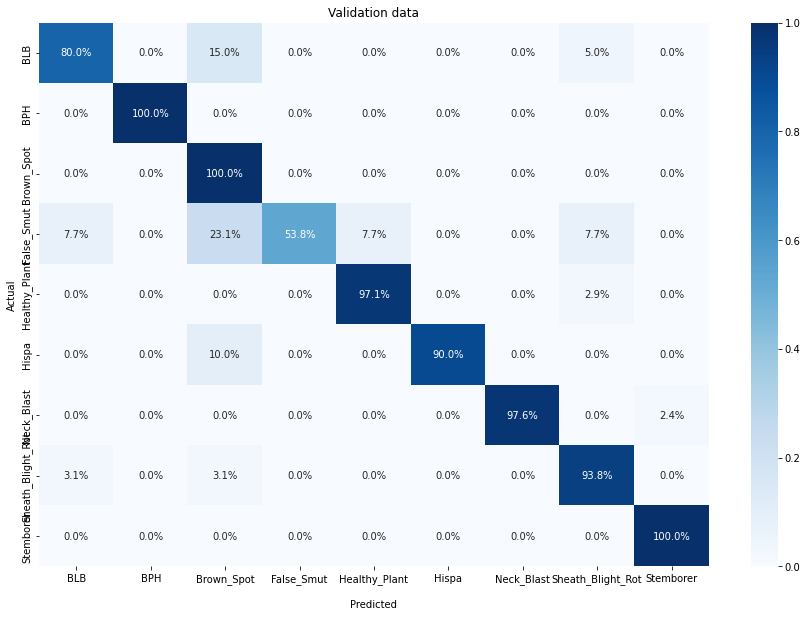

In [118]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(val_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Validation data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Train Data Confusion matrix & Classification report**


In [119]:
train_dir = '/content/drive/MyDrive/buetpaper/train'

In [120]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                   )

Found 994 images belonging to 9 classes.


In [121]:
model=load_model('/content/drive/MyDrive/VGG16/DenseNetFT.h5')

In [122]:
pred_train = model.predict_generator(train_generator)
pred_train = np.argmax(pred_train, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [123]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(train_generator.classes, pred_train, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.98      1.00      0.99        96
              BPH       1.00      0.98      0.99        49
       Brown_Spot       0.91      1.00      0.95        77
       False_Smut       1.00      0.97      0.98        65
    Healthy_Plant       0.99      0.96      0.98       163
            Hispa       1.00      0.92      0.96        51
       Neck_Blast       1.00      1.00      1.00       200
Sheath_Blight_Rot       0.98      1.00      0.99       153
        Stemborer       1.00      0.99      0.99       140

         accuracy                           0.98       994
        macro avg       0.98      0.98      0.98       994
     weighted avg       0.99      0.98      0.98       994



In [124]:
train_confusion_matrix = confusion_matrix(train_generator.classes, pred_train)
train_confusion_matrix

array([[ 96,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  48,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,  77,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,  63,   0,   0,   0,   0,   0],
       [  1,   0,   3,   0, 157,   0,   0,   2,   0],
       [  1,   0,   2,   0,   1,  47,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 200,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 153,   0],
       [  0,   0,   0,   0,   0,   0,   1,   1, 138]])

In [125]:
train_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        train_sum[i]=train_sum[i]+train_confusion_matrix[i][j]
        
        
train_confusion_matrix_percentage = train_confusion_matrix.astype(np.float32)

for i in range(9):
    for j in range(9):
        train_confusion_matrix_percentage[i][j]=train_confusion_matrix_percentage[i][j]/train_sum[i]


In [126]:
train_sum

array([ 96,  49,  77,  65, 163,  51, 200, 153, 140])

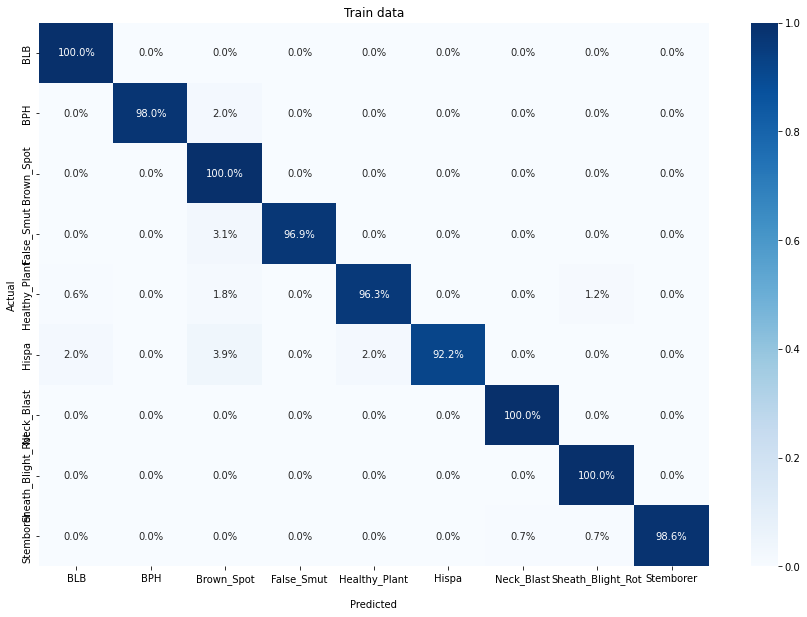

In [127]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(train_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Train data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()